In [60]:
import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [61]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
!wget <data_url>

/bin/bash: -c: line 1: syntax error near unexpected token `newline'
/bin/bash: -c: line 1: `wget <data_url>'


In [62]:
#hide
from fastbook import *
from fastai.vision.widgets import *

In [63]:
pip install --upgrade certifi

In [64]:
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai 'duckduckgo_search>=6.2'

In [65]:
!pip install duckduckgo_search

In [66]:
from duckduckgo_search import DDGS
from fastcore.all import *

def search_images(keywords, max_images=200): return L(DDGS().images(keywords, max_results=max_images)).itemgot('image')
import time, json

# Getting Data

In [67]:
urls = search_images('elliptic galaxy photos', max_images=1)
urls[0]

'https://www.universetoday.com/wp-content/uploads/2013/07/M31_JULY16_20_qhy11_tmb92_5X600_11x300_LRGB_SSP.jpg'

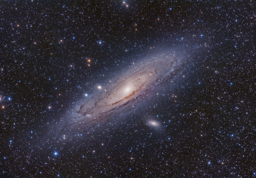

In [68]:
from fastdownload import download_url
dest = 'elliptic galaxy.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

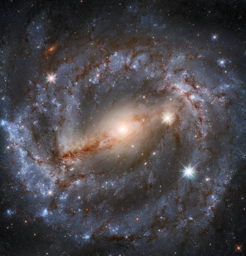

In [69]:
download_url(search_images('spiral galaxy photos', max_images=1)[0], 'spiral galaxy.jpg', show_progress=False)
Image.open('spiral galaxy.jpg').to_thumb(256,256)

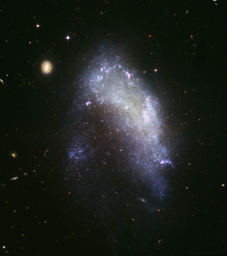

In [70]:
download_url(search_images('irregular galaxy photos', max_images=1)[0], 'irregular galaxy.jpg', show_progress=False)
Image.open('irregular galaxy.jpg').to_thumb(256,256)

In [71]:
searches = 'elliptic galaxy','spiral galaxy', 'irregular galaxy'
path = Path('elliptic or spiral or irregular')

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    time.sleep(5)
    resize_images(path/o, max_size=400, dest=path/o)

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1125: UserWarning: Couldn't allocate palette entry for transparency
  warnings.warn("Couldn't allocate palette entry for transparency")


In [72]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

7

In [73]:
class DataLoaders(GetAttr):
    def __init__(self, *loaders): self.loaders = loaders
    def __getitem__(self, i): return self.loaders[i]
    train,valid = add_props(lambda i,self: self[i])

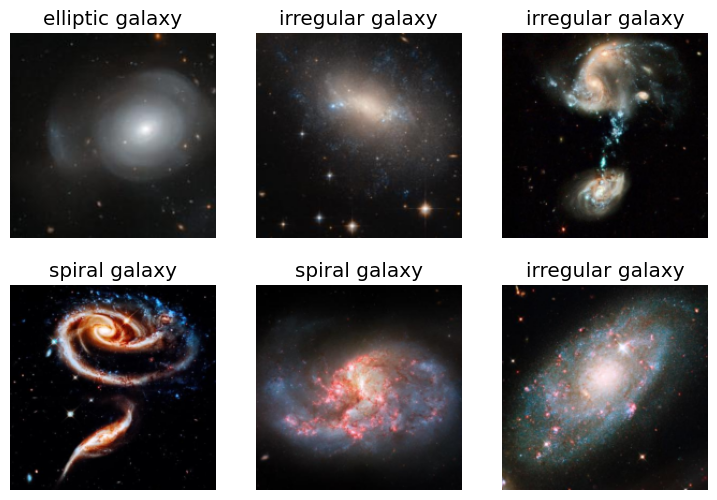

In [74]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='RandomResizedCrop')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [75]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.391365,0.902362,0.240838,00:04


epoch,train_loss,valid_loss,error_rate,time
0,0.896785,0.543840,0.162304,00:06
1,0.682940,0.500648,0.151832,00:06
2,0.537137,0.387935,0.104712,00:04
3,0.408137,0.371405,0.089005,00:04


**Data Augmentation**

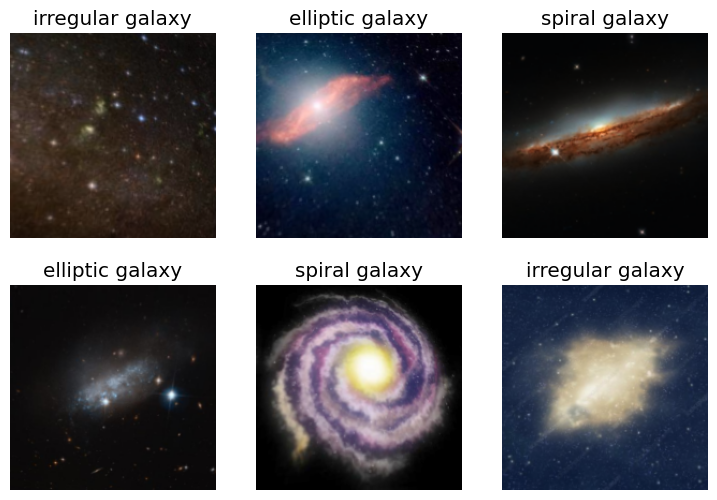

In [76]:
from fastai.vision.augment import aug_transforms

item_tfms = [Resize(192, method='RandomResizedCrop')]  # Resize for consistency
batch_tfms = aug_transforms(
)

dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=item_tfms,
    batch_tfms=batch_tfms  # Apply batch augmentations
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [77]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(5)

epoch,train_loss,valid_loss,error_rate,time
0,1.421550,0.918310,0.282723,00:06


epoch,train_loss,valid_loss,error_rate,time
0,1.007764,0.733684,0.235602,00:04
1,0.863001,0.690293,0.246073,00:04
2,0.746830,0.550172,0.162304,00:07
3,0.618299,0.486590,0.162304,00:04
4,0.559895,0.489630,0.157068,00:04


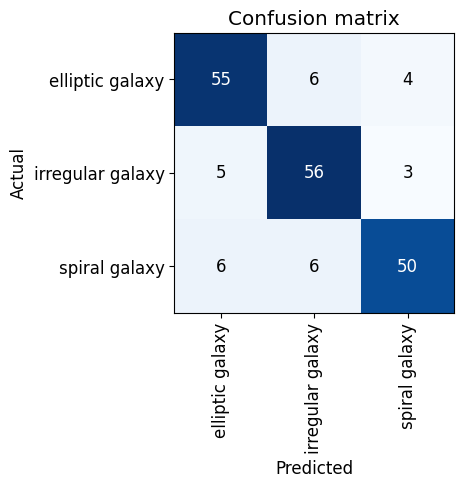

In [78]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [79]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 6))

<Figure size 2000x600 with 0 Axes>

<Figure size 2000x600 with 0 Axes>

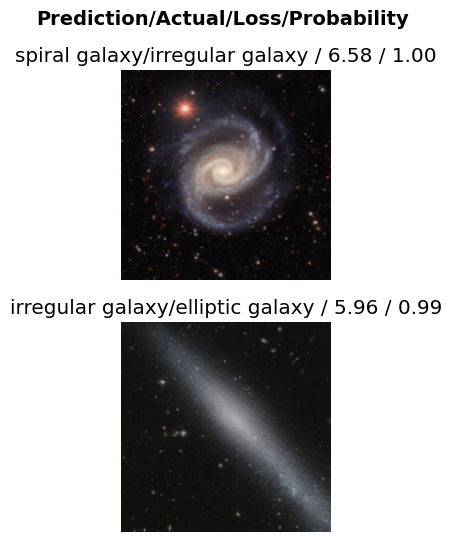

In [80]:
interp.plot_top_losses(2, nrows=2)

the second image is actually spiral so our model predicted correctly but the image label is elliptic. This means we should start doing some data cleaning and change our some of our labels

In [82]:
#hide_output
cleaner = ImageClassifierCleaner(learn)
cleaner

In [85]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()

In [86]:
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

# Online Application

In [87]:
learn.export()

In [88]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [89]:
learn_inf = load_learner(path/'export.pkl')

In [91]:
learn_inf.predict('spiral galaxy.jpg')

('spiral galaxy', tensor(2), tensor([0.0459, 0.0386, 0.9155]))

In [92]:
learn_inf.dls.vocab

['elliptic galaxy', 'irregular galaxy', 'spiral galaxy']

In [93]:
#hide_output
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [94]:
btn_upload = SimpleNamespace(data = ['elliptic galaxy.jpg'])

In [95]:
img = PILImage.create(btn_upload.data[-1])

In [96]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [97]:
pred,pred_idx,probs = learn_inf.predict(img)

In [98]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: spiral galaxy; Probability: 0.7770')

In [99]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [100]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [101]:
btn_upload = widgets.FileUpload()

In [102]:
VBox([widgets.Label('Select your bear!'),
      btn_upload, btn_run, out_pl, lbl_pred])

# Real Application

In [103]:
!pip install voila
!jupyter serverextension enable --sys-prefix voila

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 56.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.1/106.1 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.2/168.2 kB 15.5 MB/s eta 0:00:00
  Attempting uninstall: jupyter-client
    Found existing installation: jupyter-client 6.1.12
    Uninstalling jupyter-client-6.1.12:
      Successfully uninstalled jupyter-client-6.1.12
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
notebook 6.5.5 requires jupyter-client<8,>=5.3.4, but you have jupyter-client 8.6.3 which is incompatible.
Enabling: voila
- Writing config: /usr/etc/jupyter
    - Validating...
      voila 0.5.8 OK
